In [2]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import imageio

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c nfl-big-data-bowl-2024

/bin/bash: kaggle: command not found


In [4]:
!unzip nfl-big-data-bowl-2024.zip

Archive:  nfl-big-data-bowl-2024.zip
  inflating: games.csv               
  inflating: players.csv             
  inflating: plays.csv               
  inflating: tackles.csv             
  inflating: tracking_week_1.csv     
  inflating: tracking_week_2.csv     
  inflating: tracking_week_3.csv     
  inflating: tracking_week_4.csv     
  inflating: tracking_week_5.csv     
  inflating: tracking_week_6.csv     
  inflating: tracking_week_7.csv     
  inflating: tracking_week_8.csv     
  inflating: tracking_week_9.csv     


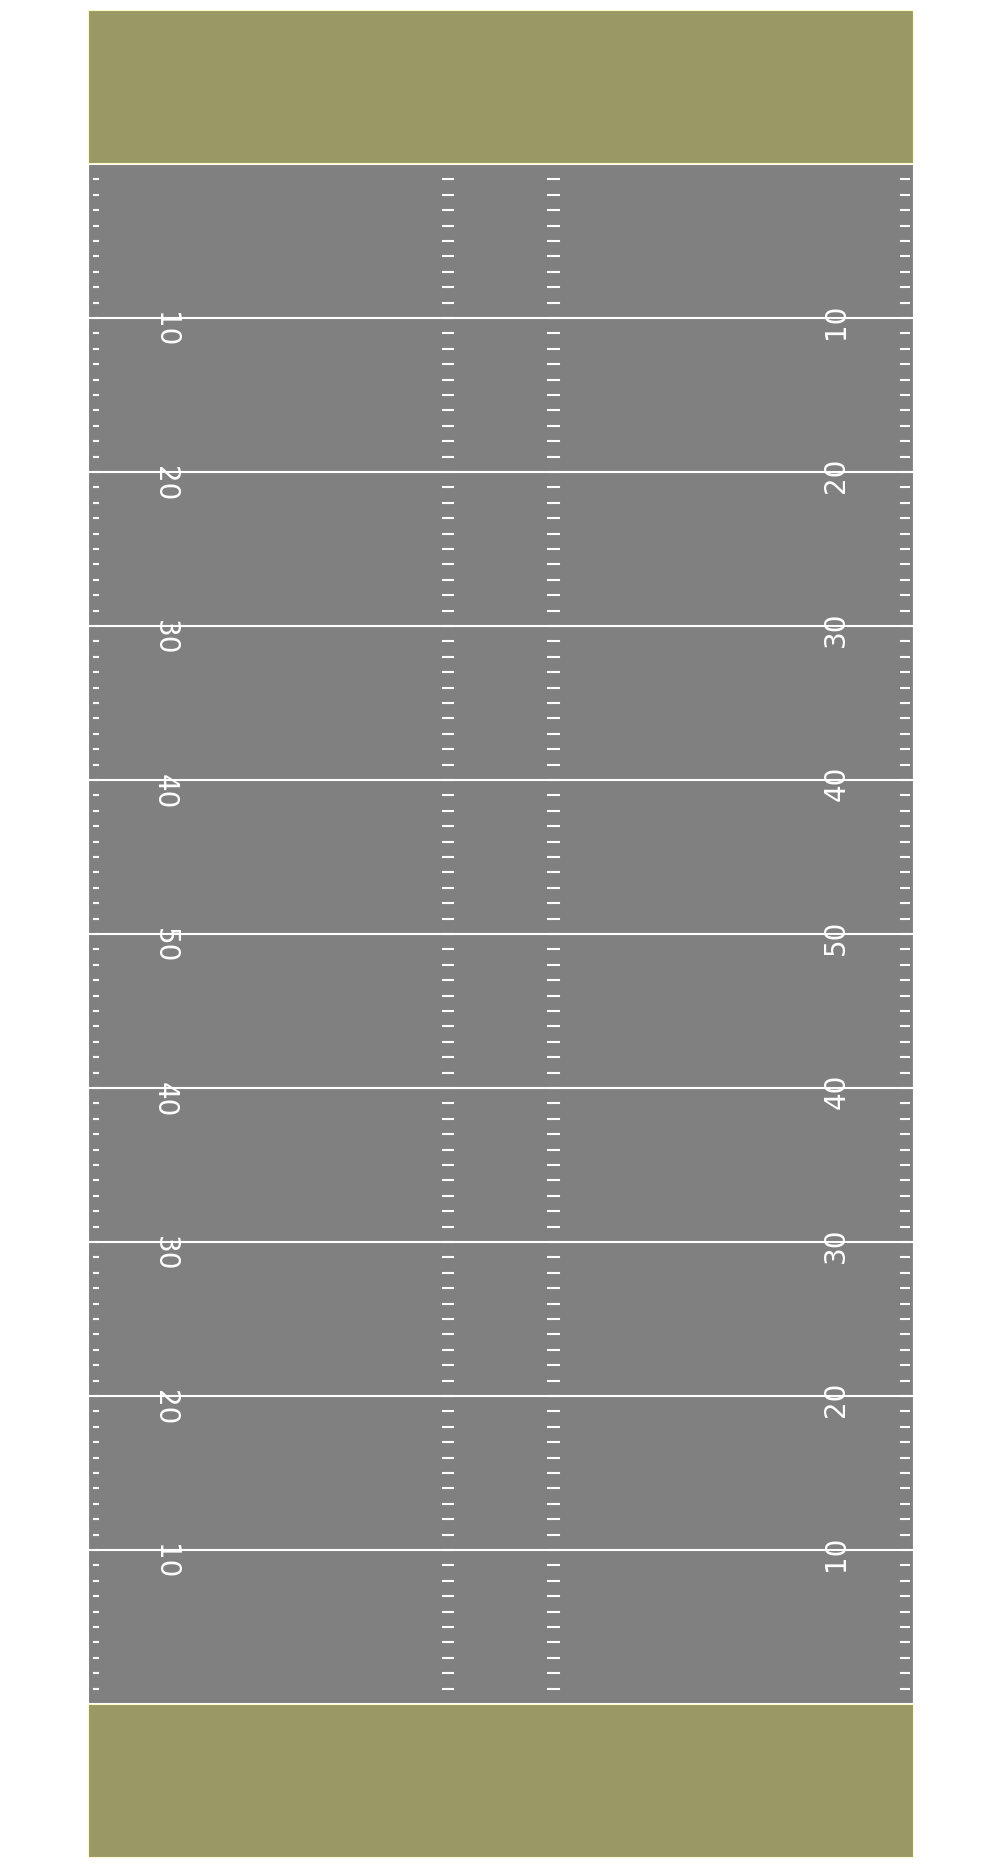

In [6]:
def create_football_field(imgSize=(12.66, 24),
                          playerCoordinatesProvided=False,
                          playerCoordinates=[],
                          labelNumbers=True,
                          showArrow=True,
                          fieldColor='gray',
                          endZoneColor='yellow',
                          first_down=False,
                          number_of_yards_left=False
                          ):
  rect = patches.Rectangle((0, 0), 53.3, 120, linewidth=0.1,
                             edgecolor='r', facecolor=fieldColor, zorder=0) #Creates the rectangle of coordinates for the field
  fig, ax = plt.subplots(1, figsize=imgSize)
  plt.plot([0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
           [10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             color='white') # plots the location of the field lines
  homeEndzone = patches.Rectangle((0, 0), 53.3, 10,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor=endZoneColor,
                                alpha=0.2,
                                zorder=10) #Plots the endzone for the home team
  awayEndzone = patches.Rectangle((0, 110), 53.3, 10,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor=endZoneColor,
                                alpha=0.2,
                                zorder=10) #Plots the endzone for the away team
  ax.add_patch(homeEndzone)
  ax.add_patch(awayEndzone)
  for y in range(20, 110, 10): #Adds the field marker numbers
            numb = y
            if y > 50:
                numb = 120 - y
            plt.text(5, y-1.5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=270)
            plt.text(53.3 - 5, y - 0.95, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=90) #
  for y in range(11,110): #Adds all of the  hash lines
        ax.plot([0.7, 0.4],[y, y], color='white')
        ax.plot([53.0, 52.5],[y, y], color='white')
        ax.plot([22.91, 23.57],[y, y], color='white')
        ax.plot([29.73, 30.39],[y, y],  color='white')
  if playerCoordinatesProvided: #Plots player coordinates
    for index, row in playerCoordinates.iterrows():
      if row['club']==row['homeTeamAbbr']:
        plt.scatter(row['y'],row['x'], color= 'red', s=300) #Given color red if home team, blue if away
        if showArrow==True:
          plt.arrow(row['y'],row['x'],row['xspeed'], row['yspeed']*0.1, color='green',width = 0.1) #if user wants direction arrow
        if labelNumbers:
          plt.annotate(int(row['jerseyNumber']), (row['y'], row['x']),xytext=(row['y']-0.5, row['x']-0.5), color='white') #if user wants jersey numbers
      elif row['club']=='football':
        plt.scatter(row['y'],row['x'], color='brown', s=100)
      else:
        plt.scatter(row['y'],row['x'], color = 'blue', s=300)
        if showArrow==True:
          plt.arrow(row['y'],row['x'],row['xspeed'], row['yspeed']*0.1, color='orange', width = 0.1)
        if labelNumbers:
          plt.annotate(int(row['jerseyNumber']), (row['y'], row['x']),xytext=(row['y']-0.5, row['x']-0.5), color='white')

  if first_down==True:
    plt.plot([0,53.3], [10+float(playerCoordinates.iloc[0]['yardlineNumber']), 10+float(playerCoordinates.iloc[0]['yardlineNumber'])], color='blue')
    plt.plot([0,53.3], [10+float(playerCoordinates.iloc[0]['yardlineNumber'])+float(playerCoordinates.iloc[0]['yardsToGo']), 10+float(playerCoordinates.iloc[0]['yardlineNumber'])+float(playerCoordinates.iloc[0]['yardsToGo'])], color='yellow')

  if number_of_yards_left==True:
    ball_carrier_x = float(playerCoordinates.loc[playerCoordinates['nflId']==playerCoordinates['ballCarrierId']].iloc[0]['x'])
    yards= float(playerCoordinates.loc[playerCoordinates['nflId']==playerCoordinates['ballCarrierId']].iloc[0]['playResult'])
    starting_point=float(10+float(playerCoordinates.iloc[0]['yardlineNumber']))
    num_yards=yards+starting_point-ball_carrier_x
    plt.text(14, 3, f"Number of Yards Left: {num_yards:.2f}", color='red', fontsize=30)

  ax.add_patch(rect)
  plt.ylim(0, 120)
  plt.xlim(-5, 58.3)
  plt.axis('off')

create_football_field()

In [7]:
week1=pd.read_csv('tracking_week_1.csv')
games=pd.read_csv('games.csv')
plays=pd.read_csv('plays.csv')
players=pd.read_csv('players.csv')
tackles = pd.read_csv('tackles.csv')
week1

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.370000,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.470000,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.560000,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.640000,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.720000,26.80,1.29,1.24,0.13,233.36,141.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407434,2022091200,3826,NaN,football,49,2022-09-12 23:05:57.799999,NaN,football,left,56.220001,9.89,2.56,1.25,0.25,NaN,NaN,tackle
1407435,2022091200,3826,NaN,football,50,2022-09-12 23:05:57.900000,NaN,football,left,56.060001,10.08,2.50,1.14,0.24,NaN,NaN,NaN
1407436,2022091200,3826,NaN,football,51,2022-09-12 23:05:58.000000,NaN,football,left,55.889999,10.27,2.38,1.70,0.25,NaN,NaN,NaN
1407437,2022091200,3826,NaN,football,52,2022-09-12 23:05:58.099999,NaN,football,left,55.730000,10.44,2.07,2.83,0.24,NaN,NaN,NaN


In [8]:
week1.loc[week1['playDirection'] == 'left', 'x'] = 120 - week1.loc[week1['playDirection'] == 'left', 'x']
week1.loc[week1['playDirection'] == 'left', 'y'] = (160/3) - week1.loc[week1['playDirection'] == 'left', 'y']
week1.loc[week1['playDirection'] == 'left', 'dir'] += 180
week1.loc[week1['dir'] > 360, 'dir'] -= 360
week1.loc[week1['playDirection'] == 'left', 'o'] += 180
week1.loc[week1['o'] > 360, 'o'] -= 360
week1

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,31.630000,26.063333,1.62,1.15,0.16,51.74,327.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,31.530000,26.203333,1.67,0.61,0.17,50.98,328.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,31.440000,26.323333,1.57,0.49,0.15,50.98,327.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,31.360000,26.433333,1.44,0.89,0.14,52.38,325.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,31.280000,26.533333,1.29,1.24,0.13,53.36,321.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407434,2022091200,3826,NaN,football,49,2022-09-12 23:05:57.799999,NaN,football,left,63.779999,43.443333,2.56,1.25,0.25,NaN,NaN,tackle
1407435,2022091200,3826,NaN,football,50,2022-09-12 23:05:57.900000,NaN,football,left,63.939999,43.253333,2.50,1.14,0.24,NaN,NaN,NaN
1407436,2022091200,3826,NaN,football,51,2022-09-12 23:05:58.000000,NaN,football,left,64.110001,43.063333,2.38,1.70,0.25,NaN,NaN,NaN
1407437,2022091200,3826,NaN,football,52,2022-09-12 23:05:58.099999,NaN,football,left,64.270000,42.893334,2.07,2.83,0.24,NaN,NaN,NaN


In [9]:
completed_passes=plays[(plays['passResult']=="C") & (plays['penaltyYards'].isna()==True)]
completed_passes

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
5,2022103001,2165,54616,Tyler Allgeier,(10:14) (Shotgun) M.Mariota pass short left to...,3,3,17,ATL,CAR,...,0.599479,0.400521,-0.030628,0.030628,-1.484904,-0.639661,NaN,NaN,NaN,NaN
9,2022092511,2903,46096,Rashaad Penny,(:35) (Shotgun) G.Smith pass short left to R.P...,3,1,10,SEA,ATL,...,0.344336,0.655664,-0.018103,0.018103,0.986438,-0.477845,NaN,NaN,NaN,NaN
12,2022091102,3336,46331,Ross Dwelley,(11:55) (Shotgun) T.Lance pass short middle to...,4,3,10,SF,CHI,...,0.632420,0.367580,-0.085709,0.085709,-0.208933,1.777092,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12472,2022092500,2194,41292,Jarvis Landry,(13:41) J.Winston pass short left to J.Landry ...,3,1,10,NO,CAR,...,0.831099,0.168901,-0.021496,0.021496,1.399707,0.840568,NaN,NaN,NaN,NaN
12478,2022100213,811,40011,Travis Kelce,(1:27) P.Mahomes pass short left to T.Kelce to...,1,2,2,KC,TB,...,0.167661,0.832339,0.001442,-0.001442,1.018668,0.354830,NaN,NaN,NaN,NaN
12479,2022092504,2509,52725,Ben Ellefson,(8:31) K.Cousins pass short right to B.Ellefso...,3,1,10,MIN,DET,...,0.569608,0.430392,0.024005,-0.024005,1.105009,0.715667,NaN,NaN,NaN,NaN
12480,2022100910,105,44959,George Kittle,(13:43) (Shotgun) J.Garoppolo pass deep left t...,1,3,6,SF,CAR,...,0.395102,0.604898,-0.068616,0.068616,0.172976,2.691196,NaN,NaN,NaN,NaN


In [10]:
completed_passes_tracking=week1.merge(completed_passes, how='inner', on=['gameId', 'playId'])
completed_passes_tracking['absoluteYardlineNumber'].unique()

array([ 85,  65,  57,  44,  36,  29,  53,  63,  59,  95,  74,  42,  34,
        80,  50,  66,  46,  38,  48,  23,  32,  25,  17,  35,  58,  88,
        76,  72,  78,  71,  51,  91,  86,  70,  84,  54,  52,  31,  82,
        40,  43,  89,  77,  79,  56,  37,  61,  81,  24,  62,  87,  30,
        60,  27,  64,  15, 102,  94,  12,  39,  90,  68,  55,  33,  75,
        41,  26,  20,  11,  45,  47,  73,  97, 107,  67,  69,  93, 106,
        99,  13, 101,  21,  16,  19, 104, 105,  96,  83,  22, 100, 103,
        98,  49, 108,  18,  92,  28])

In [11]:
completed_passes_tracking

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,31.630000,...,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,31.530000,...,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,31.440000,...,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,31.360000,...,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,31.280000,...,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424621,2022091200,3826,NaN,football,49,2022-09-12 23:05:57.799999,NaN,football,left,63.779999,...,0.508994,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN
424622,2022091200,3826,NaN,football,50,2022-09-12 23:05:57.900000,NaN,football,left,63.939999,...,0.508994,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN
424623,2022091200,3826,NaN,football,51,2022-09-12 23:05:58.000000,NaN,football,left,64.110001,...,0.508994,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN
424624,2022091200,3826,NaN,football,52,2022-09-12 23:05:58.099999,NaN,football,left,64.270000,...,0.508994,0.491006,0.282255,-0.282255,0.967420,-0.719924,NaN,NaN,NaN,NaN


In [12]:
def processToVisualize(tracking, play, game_info, gameId, playId, time):
  tracking_single=tracking.loc[(tracking['playId'] == playId) & (tracking['time']==time) & (tracking['gameId']==gameId)]
  testingNew=pd.merge(tracking_single, play, on=['gameId', 'playId'], how='inner')
  testingNew=pd.merge(testingNew, game_info, on=['gameId'], how='inner')
  testingNew['radiansDirection'] = testingNew['dir'].astype(float).apply(math.radians) #Converts angle in degrees to radians
  testingNew['xComponent']=testingNew['radiansDirection'].astype(float).apply(math.cos) #Converts angle into an x and y component
  testingNew['yComponent']=testingNew['radiansDirection'].astype(float).apply(math.sin)
  testingNew['xspeed']=testingNew['xComponent']*testingNew['s'] #Determines magnitude of speed by multiplying x and y component by magnitude of speed
  testingNew['yspeed']=testingNew['yComponent']*testingNew['s']
  return testingNew

single_play=processToVisualize(week1, plays, games, 2022090800, 56, '2022-09-08 20:24:05.200000')
single_play['yardlineNumber']

0     25
1     25
2     25
3     25
4     25
5     25
6     25
7     25
8     25
9     25
10    25
11    25
12    25
13    25
14    25
15    25
16    25
17    25
18    25
19    25
20    25
21    25
22    25
Name: yardlineNumber, dtype: int64

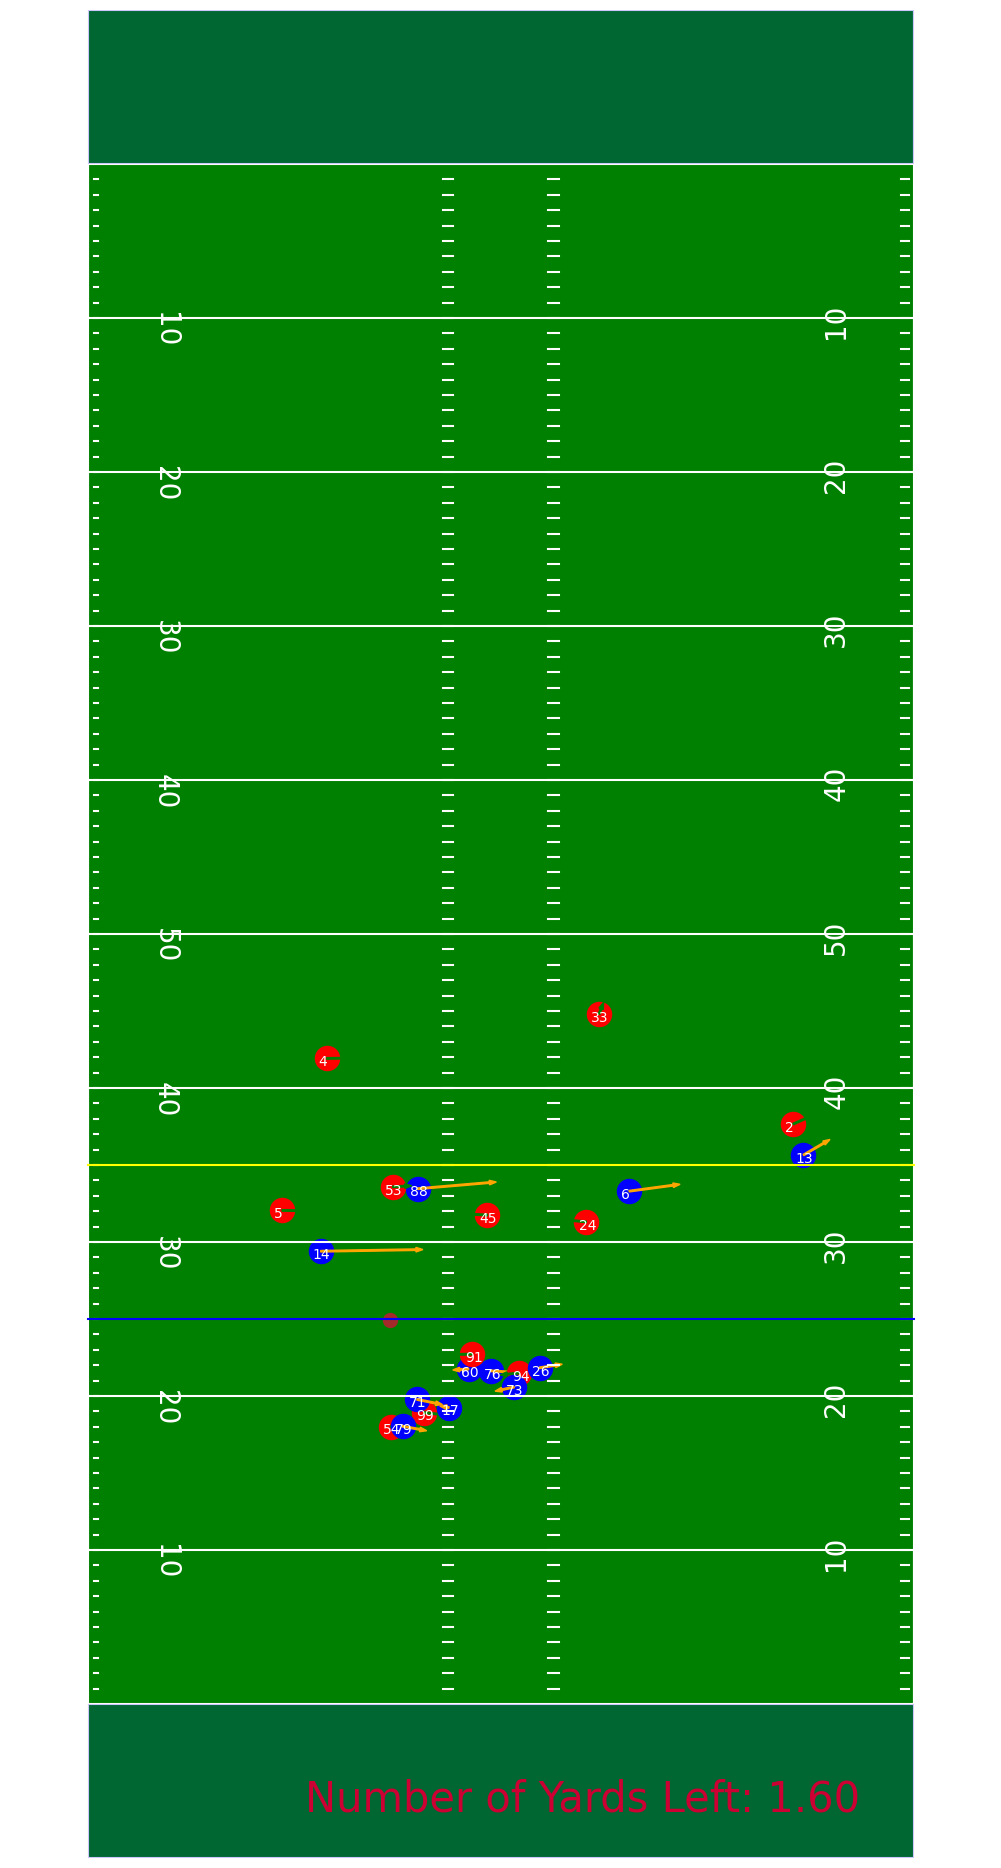

In [13]:
create_football_field(playerCoordinatesProvided=True,playerCoordinates=single_play, labelNumbers=True ,showArrow=True, fieldColor='green', endZoneColor='blue', first_down=True, number_of_yards_left=True)

In [15]:
def extractAllImagesForAPlay(tracking, plays, games, gameId, playId):
  distinctTimes=tracking.loc[(tracking['playId'] == playId)& (tracking['gameId']==gameId) ]['time'].unique()
  array_Of_Images=[]
  directory = "Play_"+str(playId)
  try:
    os.mkdir(directory)
  except:
    pass
  os.chdir(directory)
  for i in distinctTimes:
    dfForRunning=processToVisualize(tracking, plays, games, gameId, playId, i) #Goes through each time to process the data to visualize on the football field
    create_football_field(playerCoordinatesProvided=True,playerCoordinates=dfForRunning, labelNumbers=True ,showArrow=True, fieldColor='darkgreen', endZoneColor='purple', first_down=True, number_of_yards_left=True)
    plt.savefig('imgTime:'+i +".png") #saves image into the folder
    array_Of_Images.append('imgTime:'+i +".png") #creates a list of the image names
    plt.close()
  files = []
  for filename in array_Of_Images:
    files.append(imageio.imread(filename)) #appends the image to the files
  imageio.mimsave('play'+str(playId) +'.gif', files) #Generates the gif of the play
  os.chdir('..')

extractAllImagesForAPlay(week1, plays, games, 2022090800, 299)

/var/folders/pq/qr32tkk90n7361gslj40w8j4tyz0cb/T/ipykernel_65628/729153385.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  files.append(imageio.imread(filename)) #appends the image to the files


In [ ]:
week1.merge(plays, how='left', on=)

In [ ]:
plays.loc[(plays['gameId']==2022090800) & (plays['quarter']==1)]

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
1363,2022090800,236,52536,Gabe Davis,(10:03) J.Allen pass short right to G.Davis fo...,1,3,1,BUF,LA,...,0.341447,0.658553,-0.063681,0.063681,4.081674,2.918326,NaN,NaN,NaN,NaN
2308,2022090800,617,44985,Isaiah McKenzie,(2:32) (Shotgun) J.Allen pass short left to I....,1,1,10,BUF,LA,...,0.206512,0.793488,-0.002252,0.002252,1.964468,0.741917,NaN,NaN,NaN,NaN
2819,2022090800,80,46076,Josh Allen,"(14:29) (No Huddle, Shotgun) J.Allen scrambles...",1,2,4,BUF,LA,...,0.413316,0.586684,-0.013497,0.013497,1.303119,0.823571,NaN,NaN,NaN,NaN
3627,2022090800,146,47857,Devin Singletary,(12:33) (Shotgun) D.Singletary left tackle to ...,1,1,10,BUF,LA,...,0.365938,0.634062,0.021616,-0.021616,3.088262,-0.514056,NaN,NaN,NaN,NaN
4110,2022090800,364,44881,Cooper Kupp,(8:25) (Shotgun) M.Stafford pass deep right to...,1,3,8,LA,BUF,...,0.251890,0.748110,0.062175,-0.062175,-0.666246,3.124381,NaN,NaN,NaN,NaN
4477,2022090800,692,42489,Stefon Diggs,(1:25) (Shotgun) J.Allen pass short right to S...,1,1,10,BUF,LA,...,0.174776,0.825224,0.009841,-0.009841,4.058854,-0.276642,NaN,NaN,NaN,NaN
4872,2022090800,299,47853,Darrell Henderson,(9:52) D.Henderson up the middle to LA 22 for ...,1,1,10,LA,BUF,...,0.269681,0.730319,0.000072,-0.000072,0.723416,-0.105841,NaN,NaN,NaN,NaN
4889,2022090800,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,...,0.413347,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN
5055,2022090800,212,52494,Zack Moss,(10:42) (Shotgun) J.Allen pass short right to ...,1,2,9,BUF,LA,...,0.359685,0.640315,-0.018238,0.018238,3.534322,0.547352,NaN,NaN,NaN,NaN
6000,2022090800,343,47853,Darrell Henderson,(9:04) (Shotgun) D.Henderson up the middle to ...,1,2,10,LA,BUF,...,0.260003,0.739997,-0.008113,0.008113,0.070933,-0.737179,NaN,NaN,NaN,NaN


In [ ]:
def extract_remaining_yards(tracking, plays, games, game_id, play_id):
  tracking_play=tracking.loc[(tracking['playId'] == play_id) & (tracking['gameId']==game_id)]
  tracking_with_play=tracking.merge(plays, how='left', on=['game_id', 'play_id'])
  trackingplays['playResult']

In [ ]:
plays.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2'],
      dtype='object')

In [14]:
week1['event'].unique()

array([nan, 'pass_arrived', 'pass_outcome_caught', 'tackle', 'run',
       'first_contact', 'ball_snap', 'handoff', 'touchdown',
       'out_of_bounds', 'man_in_motion', 'fumble', 'play_action',
       'pass_forward', 'lateral', 'autoevent_passforward',
       'autoevent_passinterrupted', 'line_set', 'qb_slide', 'shift',
       'run_pass_option', 'qb_sack', 'pass_shovel', 'autoevent_ballsnap',
       'snap_direct', 'fumble_defense_recovered',
       'fumble_offense_recovered'], dtype=object)